In [26]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import typing
import requests
import time
import shutil
import json
from starvers.starvers import TripleStoreEngine
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [27]:
test =1
test

1

In [28]:
ifood_df = pd.read_csv(
    r"C:\Users\HP\Desktop\Business Inteligence\New folder\Business-Intelligence_Lab3\data\datasets\ifood\ml_project1_data.csv"
)
ifood_df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [29]:
# --- ATTRIBUTE TYPES ---
attribute_types = ifood_df.dtypes.astype(str)
attribute_types

ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object

In [30]:

#################################### add this to original document ####################################
print("Unique values for Z_CostContact:", ifood_df['Z_CostContact'].unique())
print("Unique values for Z_Revenue:", ifood_df['Z_Revenue'].unique())

Unique values for Z_CostContact: [3]
Unique values for Z_Revenue: [11]


In [31]:
raw_mapping = """
ID                       nominal
Year_Birth               interval
Education                ordinal
Marital_Status           nominal
Income                   ratio
Kidhome                  ratio
Teenhome                 ratio
Dt_Customer              interval
Recency                  ratio
MntWines                 ratio
MntFruits                ratio
MntMeatProducts          ratio
MntFishProducts          ratio
MntSweetProducts         ratio
MntGoldProds             ratio
NumDealsPurchases        ratio
NumWebPurchases          ratio
NumCatalogPurchases      ratio
NumStorePurchases        ratio
NumWebVisitsMonth        ratio
AcceptedCmp3             nominal-binary
AcceptedCmp4             nominal-binary
AcceptedCmp5             nominal-binary
AcceptedCmp1             nominal-binary
AcceptedCmp2             nominal-binary
Complain                 nominal-binary
Z_CostContact            unknown
Z_Revenue                unknown
Response                 nominal-binary
"""

# Step 1: Split into lines and parse
mapping_dict = {}
for line in raw_mapping.strip().split("\n"):
    parts = line.split()
    attribute = parts[0]
    measurement = parts[-1]
    mapping_dict[attribute] = measurement

# Step 2: Convert to DataFrame for nicer display
mapping_df = pd.DataFrame.from_dict(mapping_dict, orient='index', columns=['Measurement_Level'])

# Optional: reset index to turn attribute name into a column
mapping_df = mapping_df.reset_index().rename(columns={'index': 'Attribute'})

# Display
mapping_df

,Attribute,Measurement_Level
0,ID,nominal
1,Year_Birth,interval
2,Education,ordinal
3,Marital_Status,nominal
4,Income,ratio
5,Kidhome,ratio
6,Teenhome,ratio
7,Dt_Customer,interval
8,Recency,ratio
9,MntWines,ratio


In [32]:
import pandas as pd
import numpy as np

def infer_unit(col, series):
    col_lower = col.lower()

    # 1. Booleans / binary encoded variables (0/1)
    if series.dropna().nunique() == 2 and set(series.dropna().unique()).issubset({0,1}):
        return "binary indicator (0/1)"

    # 2. Date-like fields
    if "date" in col_lower or "dt" in col_lower:
        return "calendar date (YYYY-MM-DD)"

    # 3. Recency or time-distance fields
    if "recency" in col_lower:
        return "days"

    # 4. Spending / monetary amounts
    if any(x in col_lower for x in ["mnt", "meat", "fish", "wine", "fruits", "gold", "sweet"]):
        return "monetary amount (BRL)"

    # 5. Number of purchases or visits (counts)
    if col_lower.startswith("num") or "visits" in col_lower or "purchases" in col_lower:
        return "count"

    # 6. Demographic counts (kids, teens, etc.)
    if "kid" in col_lower or "teen" in col_lower or col_lower.endswith("home"):
        return "count of people"

    # 7. Income (continuous money)
    if "income" in col_lower:
        return "yearly income (BRL)"

    # 8. Synthetic fields Z_CostContact / Z_Revenue (from marketing cost model)
    if col_lower.startswith("z_"):
        return "synthetic score (unit unspecified)"

    # 9. ID is identifier
    if col_lower == "id":
        return "identifier (no unit)"

    # 10. Year of birth
    if "year_birth" in col_lower:
        return "year"

    # fallback: numeric unitless
    if np.issubdtype(series.dropna().dtype, np.number):
        return "unitless numeric value"

    # fallback for categorical
    return "categorical label (no unit)"


# Apply the function to every column
units = {col: infer_unit(col, ifood_df[col]) for col in ifood_df.columns}

# Display nicely as DataFrame
units_df = pd.DataFrame(list(units.items()), columns=["Attribute", "Unit"])
units_df


,Attribute,Unit
0,ID,identifier (no unit)
1,Year_Birth,year
2,Education,categorical label (no unit)
3,Marital_Status,categorical label (no unit)
4,Income,yearly income (BRL)
5,Kidhome,count of people
6,Teenhome,count of people
7,Dt_Customer,calendar date (YYYY-MM-DD)
8,Recency,days
9,MntWines,monetary amount (BRL)


In [33]:
import pandas as pd

# Dictionary of attribute semantics for ml_project1_data.csv
attribute_semantics = {
    "ID": "Unique customer identifier.",
    "Year_Birth": "Customer's year of birth.",
    "Education": "Customer's highest education level.",
    "Marital_Status": "Customer's marital status.",
    "Income": "Annual household income of the customer.",
    "Kidhome": "Number of children living in the customer's household.",
    "Teenhome": "Number of teenagers living in the customer's household.",
    "Dt_Customer": "Date when the customer first enrolled with the company.",
    "Recency": "Number of days since the customer's last purchase.",
    "MntWines": "Amount spent on wine products in the last 2 years.",
    "MntFruits": "Amount spent on fruit products in the last 2 years.",
    "MntMeatProducts": "Amount spent on meat products in the last 2 years.",
    "MntFishProducts": "Amount spent on fish products in the last 2 years.",
    "MntSweetProducts": "Amount spent on sweet products in the last 2 years.",
    "MntGoldProds": "Amount spent on luxury ('gold') products in the last 2 years.",
    "NumDealsPurchases": "Number of purchases made using discounts.",
    "NumWebPurchases": "Number of purchases made through the company website.",
    "NumCatalogPurchases": "Number of purchases made via catalog orders.",
    "NumStorePurchases": "Number of purchases made in physical stores.",
    "NumWebVisitsMonth": "Number of website visits in the last month.",
    "AcceptedCmp3": "Whether the customer accepted the 3rd campaign (0/1).",
    "AcceptedCmp4": "Whether the customer accepted the 4th campaign (0/1).",
    "AcceptedCmp5": "Whether the customer accepted the 5th campaign (0/1).",
    "AcceptedCmp1": "Whether the customer accepted the 1st campaign (0/1).",
    "AcceptedCmp2": "Whether the customer accepted the 2nd campaign (0/1).",
    "Complain": "Whether the customer had a complaint in the last 2 years.",
    "Z_CostContact": "No analytical meaning.",
    "Z_Revenue": "No analytical meaning.",
    "Response": "Whether the customer accepted the most recent marketing campaign.",
}
attribute_semantics

{'ID': 'Unique customer identifier.',
 'Year_Birth': "Customer's year of birth.",
 'Education': "Customer's highest education level.",
 'Marital_Status': "Customer's marital status.",
 'Income': 'Annual household income of the customer.',
 'Kidhome': "Number of children living in the customer's household.",
 'Teenhome': "Number of teenagers living in the customer's household.",
 'Dt_Customer': 'Date when the customer first enrolled with the company.',
 'Recency': "Number of days since the customer's last purchase.",
 'MntWines': 'Amount spent on wine products in the last 2 years.',
 'MntFruits': 'Amount spent on fruit products in the last 2 years.',
 'MntMeatProducts': 'Amount spent on meat products in the last 2 years.',
 'MntFishProducts': 'Amount spent on fish products in the last 2 years.',
 'MntSweetProducts': 'Amount spent on sweet products in the last 2 years.',
 'MntGoldProds': "Amount spent on luxury ('gold') products in the last 2 years.",
 'NumDealsPurchases': 'Number of pur

In [34]:
# ---------------------------------------
# 1. BASIC STATISTICS FOR EACH ATTRIBUTE
# ---------------------------------------

# Numeric columns only
numeric_cols = [
    "Year_Birth", "Income", "Kidhome", "Teenhome", "Recency",
    "MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts",
    "MntSweetProducts", "MntGoldProds",
    "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases",
    "NumStorePurchases", "NumWebVisitsMonth"
]

basic_stats = pd.DataFrame({
    "mean": ifood_df[numeric_cols].mean(),
    "median": ifood_df[numeric_cols].median(),
    "min": ifood_df[numeric_cols].min(),
    "max": ifood_df[numeric_cols].max(),
    "variance": ifood_df[numeric_cols].var(),
    "std_dev": ifood_df[numeric_cols].std(),
    "skewness": ifood_df[numeric_cols].skew(),
    "mode": ifood_df[numeric_cols].mode().iloc[0]
})

print("\n=== BASIC STATISTICS FOR NUMERIC ATTRIBUTES ===")
display(basic_stats)



=== BASIC STATISTICS FOR NUMERIC ATTRIBUTES ===


,mean,median,min,max,variance,std_dev,skewness,mode
Year_Birth,1968.805804,1970.0,1893.0,1996.0,1.436179e+02,11.984069,-0.349944,1976.0
Income,52247.251354,51381.5,1730.0,666666.0,6.336838e+08,25173.076661,6.763487,7500.0
Kidhome,0.444196,0.0,0.0,2.0,2.898725e-01,0.538398,0.635288,0.0
Teenhome,0.506250,0.0,0.0,2.0,2.965219e-01,0.544538,0.407115,0.0
Recency,49.109375,49.0,0.0,99.0,8.388237e+02,28.962453,-0.001987,56.0
MntWines,303.935714,173.5,0.0,1493.0,1.132978e+05,336.597393,1.175771,2.0
MntFruits,26.302232,8.0,0.0,199.0,1.581926e+03,39.773434,2.102063,0.0
MntMeatProducts,166.950000,67.0,0.0,1725.0,5.094743e+04,225.715373,2.083233,7.0
MntFishProducts,37.525446,12.0,0.0,259.0,2.984325e+03,54.628979,1.919769,0.0
MntSweetProducts,27.062946,8.0,0.0,263.0,1.704080e+03,41.280498,2.136081,0.0


,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
Year_Birth,1.000000,-0.161791,0.230176,-0.352111,-0.019871,-0.157773,-0.017917,-0.030872,-0.041625,-0.018133,-0.061818,-0.060846,-0.145040,-0.121275,-0.128272,0.121139
Income,-0.161791,1.000000,-0.428669,0.019133,-0.003970,0.578650,0.430842,0.584633,0.438871,0.440744,0.325916,-0.083101,0.387878,0.589162,0.529362,-0.553088
Kidhome,0.230176,-0.428669,1.000000,-0.036133,0.008827,-0.496297,-0.372581,-0.437129,-0.387644,-0.370673,-0.349595,0.221798,-0.361647,-0.502237,-0.499683,0.447846
Teenhome,-0.352111,0.019133,-0.036133,1.000000,0.016198,0.004846,-0.176764,-0.261160,-0.204187,-0.162475,-0.021725,0.387741,0.155500,-0.110769,0.050695,0.134884
Recency,-0.019871,-0.003970,0.008827,0.016198,1.000000,0.016064,-0.004306,0.023056,0.001079,0.022670,0.016693,-0.001098,-0.010726,0.025110,0.000799,-0.021445
MntWines,-0.157773,0.578650,-0.496297,0.004846,0.016064,1.000000,0.389637,0.562667,0.399753,0.386581,0.387516,0.010940,0.542265,0.635226,0.642100,-0.320653
MntFruits,-0.017917,0.430842,-0.372581,-0.176764,-0.004306,0.389637,1.000000,0.543105,0.594804,0.567164,0.392995,-0.132114,0.296735,0.487917,0.461758,-0.418383
MntMeatProducts,-0.030872,0.584633,-0.437129,-0.261160,0.023056,0.562667,0.543105,1.000000,0.568402,0.523846,0.350609,-0.122415,0.293761,0.723827,0.479659,-0.539470
MntFishProducts,-0.041625,0.438871,-0.387644,-0.204187,0.001079,0.399753,0.594804,0.568402,1.000000,0.579870,0.422875,-0.139361,0.293681,0.534478,0.459855,-0.446003
MntSweetProducts,-0.018133,0.440744,-0.370673,-0.162475,0.022670,0.386581,0.567164,0.523846,0.579870,1.000000,0.369724,-0.120100,0.348544,0.490924,0.448756,-0.423294


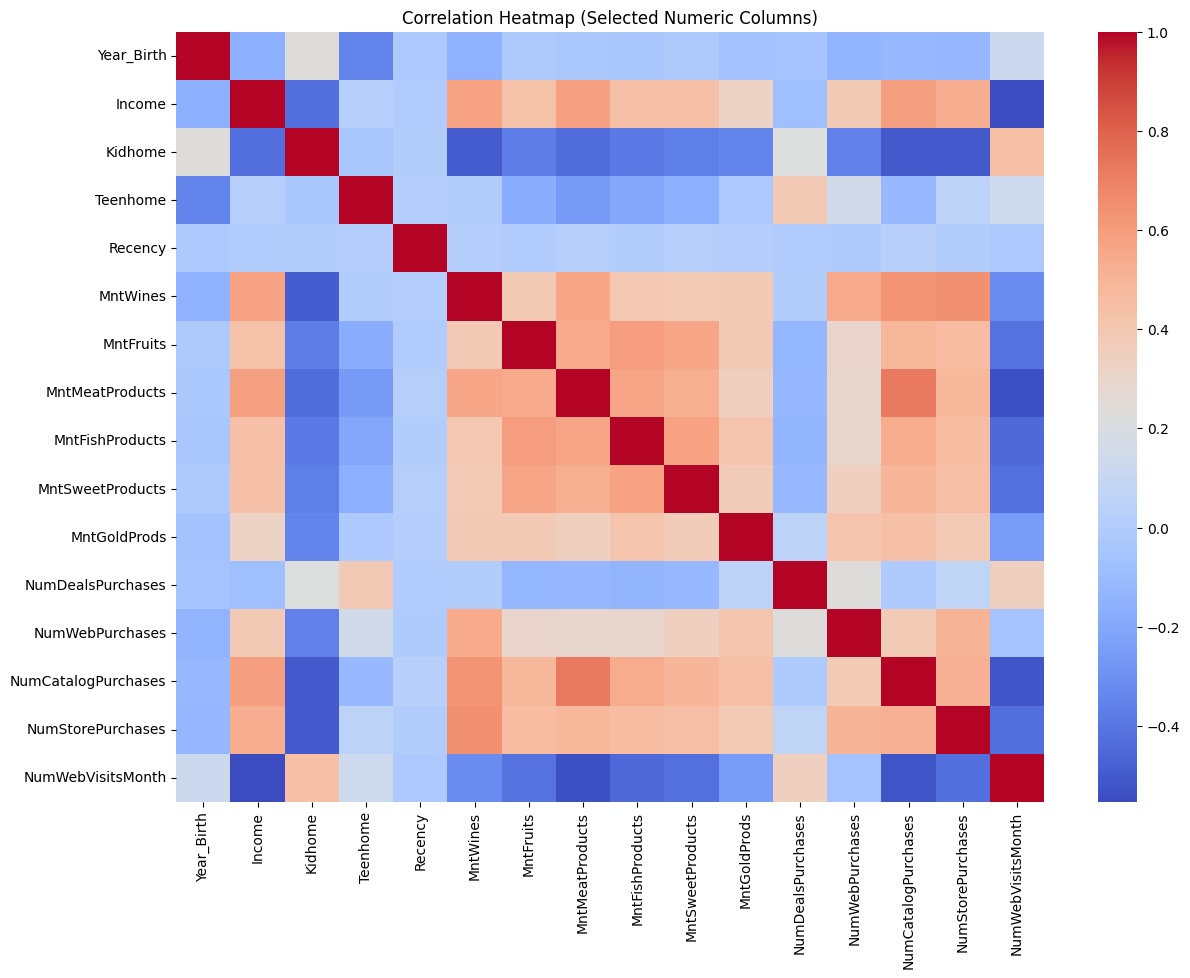

In [35]:
corr_matrix = ifood_df[numeric_cols].corr()
display(corr_matrix)

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Selected Numeric Columns)")
plt.show()

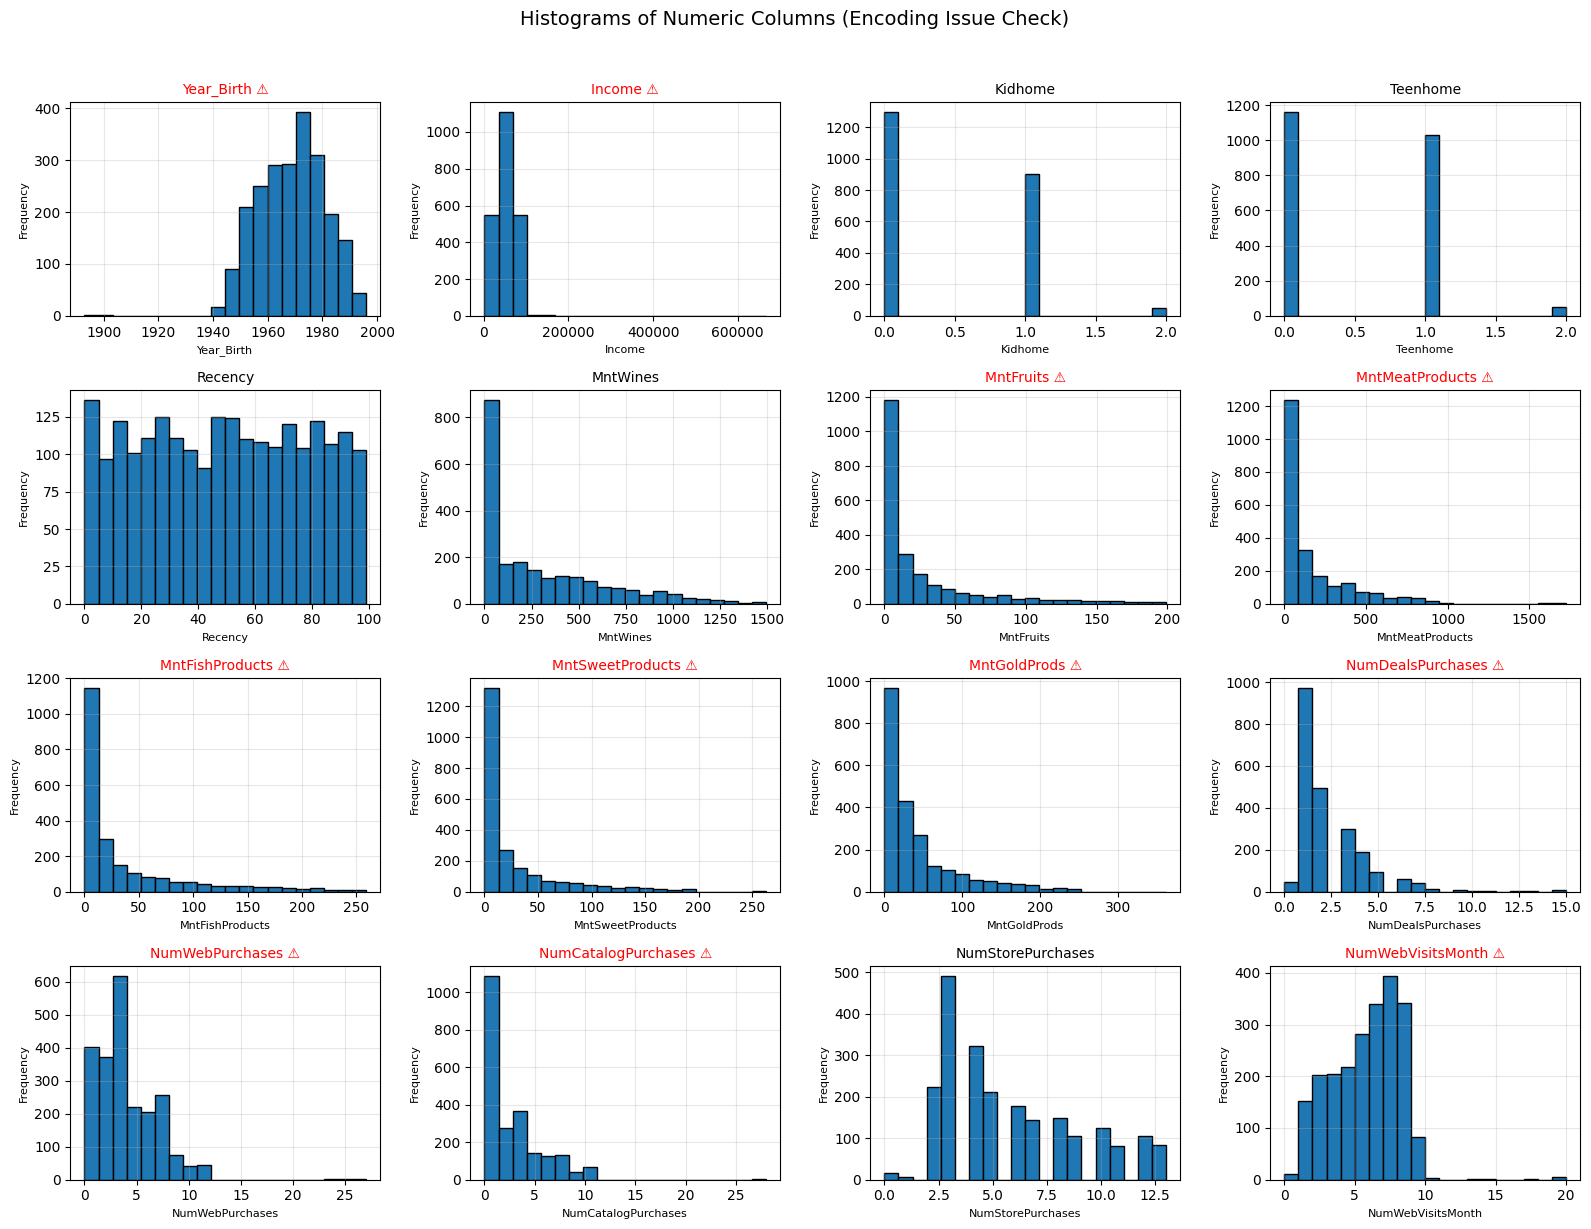


=== ENCODING WARNINGS SUMMARY ===

⚠ Year_Birth:
  - Extreme outliers (|z| > 4)
  - Impossible year values

⚠ Income:
  - Extreme outliers (|z| > 4)

⚠ MntFruits:
  - Extreme outliers (|z| > 4)

⚠ MntMeatProducts:
  - Extreme outliers (|z| > 4)

⚠ MntFishProducts:
  - Extreme outliers (|z| > 4)

⚠ MntSweetProducts:
  - Extreme outliers (|z| > 4)

⚠ MntGoldProds:
  - Extreme outliers (|z| > 4)

⚠ NumDealsPurchases:
  - Extreme outliers (|z| > 4)

⚠ NumWebPurchases:
  - Extreme outliers (|z| > 4)

⚠ NumCatalogPurchases:
  - Extreme outliers (|z| > 4)

⚠ NumWebVisitsMonth:
  - Extreme outliers (|z| > 4)


In [36]:
def get_encoding_warnings(df, col):
    """Return list of encoding warnings for a numeric column."""
    data = df[col].dropna()
    warnings = []

    # Constant column
    if data.nunique() == 1:
        warnings.append("Constant value")

    # Check extreme outliers using z-score
    zscores = (data - data.mean()) / data.std()
    if (np.abs(zscores) > 4).any():
        warnings.append("Extreme outliers (|z| > 4)")

    # Impossible values based on variable name
    col_lower = col.lower()
    if "year" in col_lower and ((data < 1925).any() or (data > 2025).any()):
        warnings.append("Impossible year values")
    if "income" in col_lower and (data < 0).any():
        warnings.append("Negative income")

    return warnings


# Create grid layout
n_cols = 4
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 3))
axes = axes.flatten()

all_warnings = {}

for i, col in enumerate(numeric_cols):
    data = ifood_df[col].dropna()
    axes[i].hist(data, bins=20, edgecolor='black')
    axes[i].set_title(col, fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel("Frequency", fontsize=8)
    axes[i].grid(True, alpha=0.3)
    
    # Collect warnings
    warnings = get_encoding_warnings(ifood_df, col)
    if warnings:
        all_warnings[col] = warnings
        axes[i].set_title(f"{col} ⚠", fontsize=10, color='red')

# Hide unused subplots
for j in range(len(numeric_cols), len(axes)):
    axes[j].axis("off")

plt.suptitle("Histograms of Numeric Columns (Encoding Issue Check)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print all warnings
print("\n=== ENCODING WARNINGS SUMMARY ===")
for col, warnings in all_warnings.items():
    print(f"\n⚠ {col}:")
    for w in warnings:
        print(f"  - {w}")

if not all_warnings:
    print("✓ No obvious encoding issues detected.")


In [37]:
# =============================================================================
# 4. OUTLIER DETECTION (Z-scores for selected numerical columns)
# =============================================================================
outlier_summary = {}

for col in numeric_cols:
    series = ifood_df[col]
    if series.std() == 0:
        continue  # no variation, skip outlier check
    z = (series - series.mean()) / series.std()
    outliers = (np.abs(z) > 4).sum()

    if outliers > 0:
        outlier_summary[col] = f"{outliers} extreme outliers detected (|z| > 4)."

print("\n=== Outlier Summary ===")
display(outlier_summary)



=== Outlier Summary ===


{'Year_Birth': '3 extreme outliers detected (|z| > 4).',
 'Income': '8 extreme outliers detected (|z| > 4).',
 'MntFruits': '10 extreme outliers detected (|z| > 4).',
 'MntMeatProducts': '5 extreme outliers detected (|z| > 4).',
 'MntFishProducts': '4 extreme outliers detected (|z| > 4).',
 'MntSweetProducts': '9 extreme outliers detected (|z| > 4).',
 'MntGoldProds': '4 extreme outliers detected (|z| > 4).',
 'NumDealsPurchases': '19 extreme outliers detected (|z| > 4).',
 'NumWebPurchases': '4 extreme outliers detected (|z| > 4).',
 'NumCatalogPurchases': '4 extreme outliers detected (|z| > 4).',
 'NumWebVisitsMonth': '6 extreme outliers detected (|z| > 4).'}

In [38]:
# 1. Categorical attributes (object dtype)
categorical_cols = ifood_df.select_dtypes(include="object").columns.tolist()

# 2. Nominal-binary attributes (numeric columns with only {0,1})
binary_cols = [
    col for col in ifood_df.columns
    if ifood_df[col].dtype in ("int64", "float64")
    and set(ifood_df[col].dropna().unique()).issubset({0, 1})
]

# 3. Combine both types
categorical_like_cols = categorical_cols + binary_cols

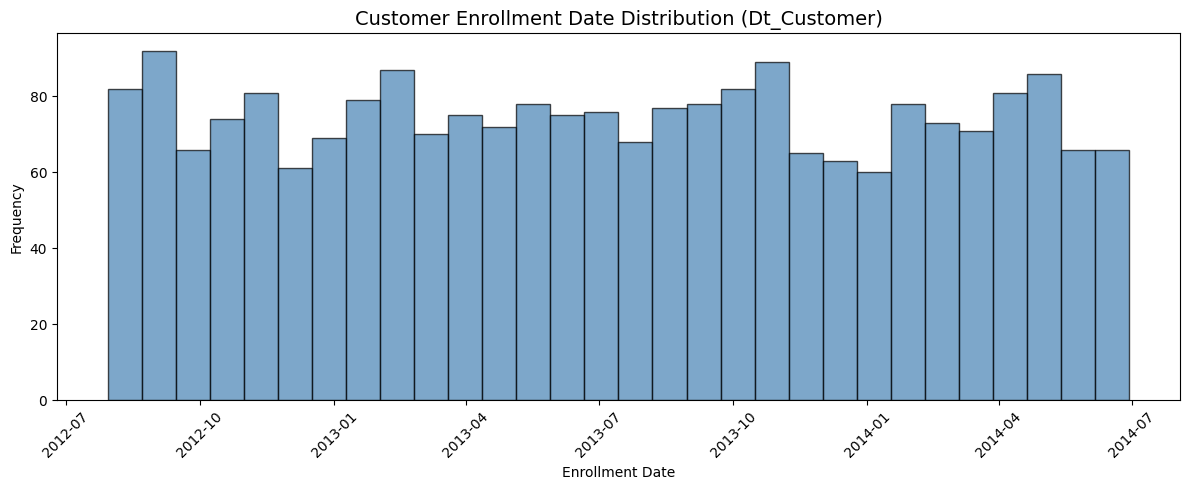

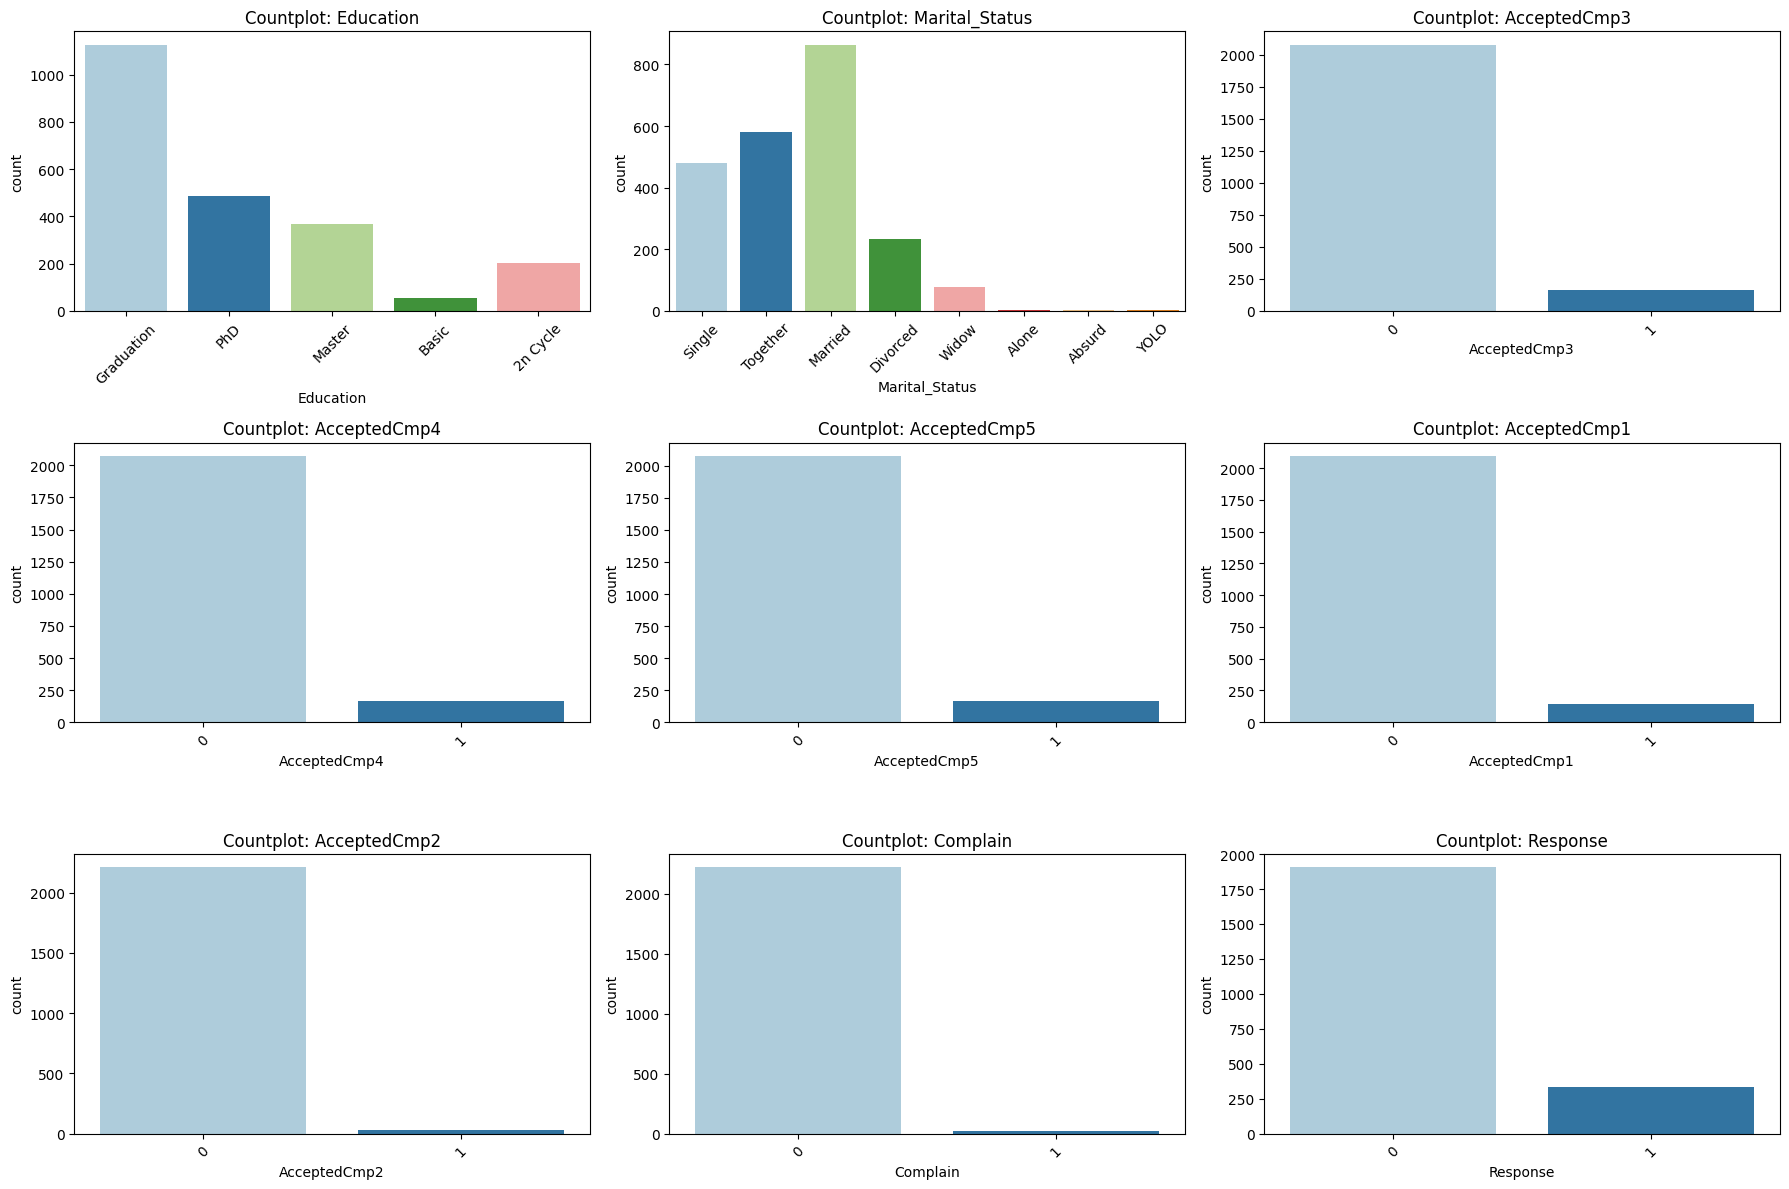

In [39]:
# -------------------------------------------------------------
# VISUALIZE EACH CATEGORICAL-LIKE ATTRIBUTE INDIVIDUALLY
# -------------------------------------------------------------
categorical_like_cols = [c for c in (categorical_cols + binary_cols) if c != "Dt_Customer"]
# Visualize Dt_Customer distribution (date-appropriate visualization)
plt.figure(figsize=(12, 5))
dt_customer_dates = pd.to_datetime(ifood_df['Dt_Customer'])
plt.hist(dt_customer_dates, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Customer Enrollment Date Distribution (Dt_Customer)', fontsize=14)
plt.xlabel('Enrollment Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

def plot_categorical_overview(df, cols):
    n = len(cols)
    cols_per_row = 3
    rows = (n + cols_per_row - 1) // cols_per_row

    fig, axes = plt.subplots(rows, cols_per_row, figsize=(18, rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.countplot(x=df[col], ax=axes[i], hue=df[col], palette="Paired", legend=False)
        axes[i].set_title(f"Countplot: {col}")
        axes[i].tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

plot_categorical_overview(ifood_df, categorical_like_cols)



In [40]:
# -----------------------------------------------------------
# ENCODING ISSUE CHECKS FOR CATEGORICAL-LIKE COLUMNS
# -----------------------------------------------------------
import re

def check_categorical_encoding(col, series):
    warnings = []

    # Convert to strings for uniform handling
    values = series.astype(str).str.strip()

    #placeholder values
    placeholder_patterns = ["unknown", "unk", "none", "null", "na", "n/a", r"^\?$", "^\-$"]
    lower_values = values.str.lower().unique()

    for p in placeholder_patterns:
        matches = [v for v in lower_values if re.fullmatch(p, v)]
        if matches:
            warnings.append(f"Contains placeholder-like values: {matches}")

    # inconsistent capitalization
    if len(set(values)) != len(set(values.str.lower())):
        warnings.append("Possible inconsistent capitalization across categories.")

    # rare categories (frequency < 1%)
    value_counts = values.value_counts(normalize=True)
    rare = value_counts[value_counts < 0.01]
    if col != "Dt_Customer" and not rare.empty:
        warnings.append(f"Contains rare categories (<1% frequency): {list(rare.index)}")

    # mixed numeric and text (possible encoding issue)
    numeric_like = values.str.fullmatch(r"[0-9]+").sum()
    if 0 < numeric_like < len(values):
        warnings.append("Contains mixture of numeric-like and text categories.")

    # binary imbalance (only for binary attributes)
    if series.name in binary_cols:
        zero_pct = (series == 0).mean()
        one_pct = (series == 1).mean()
        if zero_pct < 0.20 or one_pct < 0.20:
            warnings.append(f"Highly imbalanced binary variable: 0={zero_pct:.3f}, 1={one_pct:.3f}")

    return warnings


encoding_issues = {}
for col in categorical_like_cols:
    warnings = check_categorical_encoding(col, ifood_df[col])
    if warnings:
        encoding_issues[col] = warnings
        print(f"\n⚠ Encoding issues detected in '{col}':")
        for w in warnings:
            print("  - " + w)
    else:
        print(f"\n✓ No encoding issues detected in '{col}'")





# -----------------------------------------------------------
# RUN ENCODING CHECKS
# -----------------------------------------------------------

encoding_issues = {}

for col in categorical_like_cols:
    warnings = check_categorical_encoding(col, ifood_df[col])
    if warnings:
        encoding_issues[col] = warnings
        print(f"\n⚠ Encoding issues detected in '{col}':")
        for w in warnings:
            print("  - " + w)
    else:
        print(f"\n✓ No encoding issues detected in '{col}'")


✓ No encoding issues detected in 'Education'

⚠ Encoding issues detected in 'Marital_Status':
  - Contains rare categories (<1% frequency): ['Alone', 'Absurd', 'YOLO']

⚠ Encoding issues detected in 'AcceptedCmp3':
  - Highly imbalanced binary variable: 0=0.927, 1=0.073

⚠ Encoding issues detected in 'AcceptedCmp4':
  - Highly imbalanced binary variable: 0=0.925, 1=0.075

⚠ Encoding issues detected in 'AcceptedCmp5':
  - Highly imbalanced binary variable: 0=0.927, 1=0.073

⚠ Encoding issues detected in 'AcceptedCmp1':
  - Highly imbalanced binary variable: 0=0.936, 1=0.064

⚠ Encoding issues detected in 'AcceptedCmp2':
  - Highly imbalanced binary variable: 0=0.987, 1=0.013

⚠ Encoding issues detected in 'Complain':
  - Contains rare categories (<1% frequency): ['1']
  - Highly imbalanced binary variable: 0=0.991, 1=0.009

⚠ Encoding issues detected in 'Response':
  - Highly imbalanced binary variable: 0=0.851, 1=0.149

✓ No encoding issues detected in 'Education'

⚠ Encoding issues d

Income shows strong positive correlations with product spending and catalog/store purchases, indicating that wealthier customers consistently spend more and exhibit different purchasing behaviors. A predictive model may therefore unintentionally favor high-income individuals, leading to socioeconomic bias. Age shows moderate negative correlations with website visits and moderate positive correlations with Teenhome, revealing behavioral segmentation where younger customers are more digitally active. Although Age and Income are not legally protected attributes, they act as proxy-sensitive variables and may introduce indirect bias into the model. These effects should be considered when evaluating fairness and designing marketing strategies.

In [41]:
# =============================================================================
# 1. MISSING VALUE ANALYSIS
# =============================================================================

missing_counts = ifood_df.isna().sum()
missing_summary = pd.DataFrame({
    "Missing_Count": missing_counts[missing_counts > 0]
})

print("\n=== Missing Value Summary ===")
display(missing_summary)


=== Missing Value Summary ===


,Missing_Count
Income,24


In [42]:
import uuid


uuid.uuid4()


UUID('94d0a10c-7af8-4c79-a703-850cd5ab9f9f')

In [43]:

# Attributes to exclude (no predictive value)
excluded_columns = ['ID', 'Z_CostContact', 'Z_Revenue', 'Complain']

# Attributes to transform
transform_columns = {
    'Year_Birth': 'Age',
    'Dt_Customer': 'CustomerTenure',
    'Kidhome + Teenhome': 'TotalChildren',
    'Marital_Status': 'Consolidate rare categories',
    'AcceptedCmp1-5 + Response': 'TotalCampaignsAccepted'
}

# Target variable components
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

print(f"Excluded: {excluded_columns}")
print(f"Target: TotalSpending = sum({spending_columns})")

Excluded: ['ID', 'Z_CostContact', 'Z_Revenue', 'Complain']
Target: TotalSpending = sum(['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'])


In [44]:
# Drop excluded columns from ifood_df
#data selection part
ifood_df = ifood_df.drop(columns=excluded_columns)
print(f"Dropped columns: {excluded_columns}")
print(f"Remaining columns: {ifood_df.shape[1]}")
ifood_df.head()

Dropped columns: ['ID', 'Z_CostContact', 'Z_Revenue', 'Complain']
Remaining columns: 25


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,8,10,4,7,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,1,1,2,5,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,8,2,10,4,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,2,0,4,6,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,5,3,6,5,0,0,0,0,0,0


In [45]:
# Display customers with missing Income data (from original dataset)
missing_income_df = ifood_df[ifood_df['Income'].isna()]
print(f"Customers with missing Income: {len(missing_income_df)}")
missing_income_df.head()

Customers with missing Income: 24


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response
10,1983,Graduation,Married,NaN,1,0,2013-11-15,11,5,5,...,1,0,2,7,0,0,0,0,0,0
27,1986,Graduation,Single,NaN,1,0,2013-02-20,19,5,1,...,27,0,0,1,0,0,0,0,0,0
43,1959,PhD,Single,NaN,0,0,2013-11-05,80,81,11,...,1,3,4,2,0,0,0,0,0,0
48,1951,Graduation,Single,NaN,2,1,2014-01-01,96,48,5,...,2,1,4,6,0,0,0,0,0,0
58,1982,Graduation,Single,NaN,1,0,2013-06-17,57,11,3,...,2,0,3,6,0,0,0,0,0,0


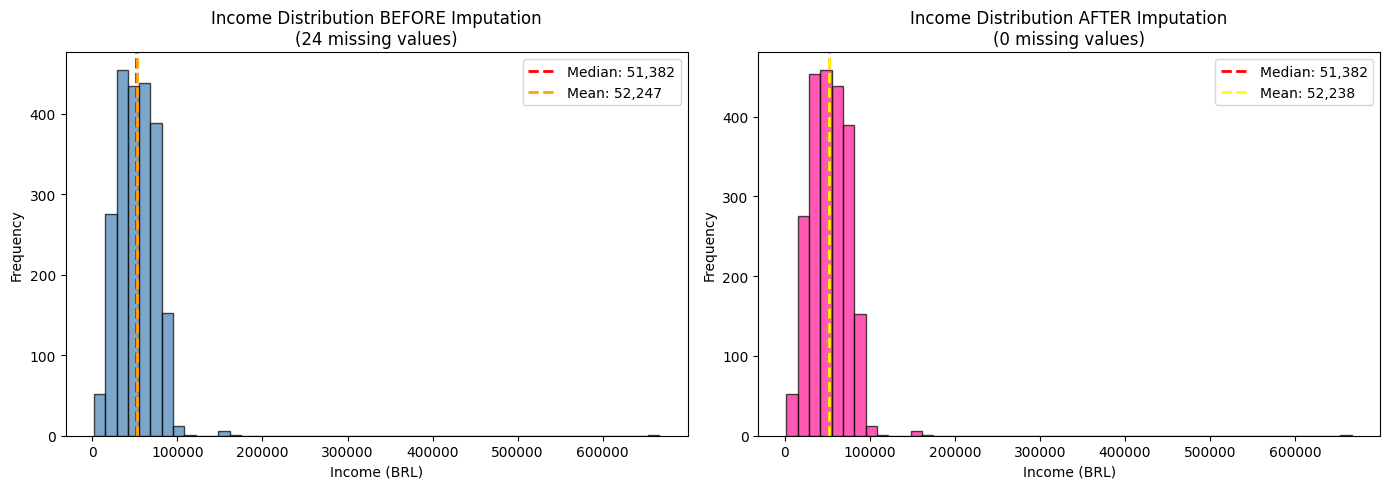


Missing values imputation for 'Income' attribute:
Missing values before: 24
Missing values after:  0
Imputation method: Median (51,381.50 BRL)


In [ ]:

#reload fresh data to capture before state (in case cell is re-run)
marketing_data_path = os.path.join("data", "datasets", "ifood")
ifood_df_original = pd.read_csv(os.path.join(marketing_data_path, "ml_project1_data.csv"))
missing_count_before = ifood_df_original['Income'].isna().sum()

#visualize Income distribution with missing values
income_before = ifood_df_original['Income'].dropna()

plt.figure(figsize=(14, 5))

#Left plot: Income distribution before imputation (from original data)
plt.subplot(1, 2, 1)
plt.hist(income_before, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(income_before.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {income_before.median():,.0f}')
plt.axvline(income_before.mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: {income_before.mean():,.0f}')
plt.title(f'Income Distribution BEFORE Imputation\n({missing_count_before} missing values)', fontsize=12)
plt.xlabel('Income (BRL)')
plt.ylabel('Frequency')
plt.legend()

# Store median value for imputation (from original data with missing values)
income_median = ifood_df_original['Income'].median()

# Perform median imputation on the working dataframe
ifood_df['Income'] = ifood_df['Income'].fillna(income_median)

# Right plot: Income distribution AFTER imputation
income_after = ifood_df['Income']
missing_count_after = ifood_df['Income'].isna().sum()

# Right plot: AFTER imputation
plt.subplot(1, 2, 2)
plt.hist(income_after, bins=50, color='deeppink', edgecolor='black', alpha=0.7)
plt.axvline(income_after.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {income_after.median():,.0f}')
plt.axvline(income_after.mean(), color='yellow', linestyle='--', linewidth=2, label=f'Mean: {income_after.mean():,.0f}')
plt.title(f'Income Distribution AFTER Imputation\n({missing_count_after} missing values)', fontsize=12)
plt.xlabel('Income (BRL)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nMissing values imputation for 'Income' attribute:")
print(f"Missing values before: {missing_count_before}")
print(f"Missing values after:  {missing_count_after}")
print(f"Imputation method: Median ({income_median:,.2f} BRL)")

# =============================================================================
# INCOME OUTLIER HANDLING
# =============================================================================
print("\n" + "="*60)
print("INCOME OUTLIER HANDLING")
print("="*60)

# Detect outliers using IQR method
Q1 = ifood_df['Income'].quantile(0.25)
Q3 = ifood_df['Income'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
income_outliers_mask = (ifood_df['Income'] < lower_bound) | (ifood_df['Income'] > upper_bound)
outlier_count_before = income_outliers_mask.sum()
outlier_values = ifood_df.loc[income_outliers_mask, 'Income']

print(f"\nIQR Method bounds:")
print(f"  Q1: {Q1:,.0f} BRL")
print(f"  Q3: {Q3:,.0f} BRL")
print(f"  IQR: {IQR:,.0f} BRL")
print(f"  Lower bound: {lower_bound:,.0f} BRL")
print(f"  Upper bound: {upper_bound:,.0f} BRL")
print(f"\nOutliers detected: {outlier_count_before}")

if outlier_count_before > 0:
    print(f"Outlier Income values: min={outlier_values.min():,.0f}, max={outlier_values.max():,.0f}")

# Visualize before/after outlier handling
plt.figure(figsize=(14, 5))

# Left: Before outlier handling (with outliers highlighted)
plt.subplot(1, 2, 1)
plt.hist(ifood_df['Income'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(upper_bound, color='red', linestyle='--', linewidth=2, label=f'Upper bound: {upper_bound:,.0f}')
plt.axvline(lower_bound, color='orange', linestyle='--', linewidth=2, label=f'Lower bound: {lower_bound:,.0f}')
plt.title(f'Income Distribution BEFORE Outlier Handling\n({outlier_count_before} outliers)', fontsize=12)
plt.xlabel('Income (BRL)')
plt.ylabel('Frequency')
plt.legend()

# Cap outliers at upper/lower bounds (winsorization)
ifood_df.loc[ifood_df['Income'] > upper_bound, 'Income'] = upper_bound
ifood_df.loc[ifood_df['Income'] < lower_bound, 'Income'] = lower_bound

# Verify outliers are handled
outliers_after = ((ifood_df['Income'] < lower_bound) | (ifood_df['Income'] > upper_bound)).sum()

# Right: After outlier handling
plt.subplot(1, 2, 2)
plt.hist(ifood_df['Income'], bins=50, color='hotpink', edgecolor='black', alpha=0.7)
plt.axvline(ifood_df['Income'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {ifood_df['Income'].median():,.0f}")
plt.axvline(ifood_df['Income'].mean(), color='yellow', linestyle='--', linewidth=2, label=f"Mean: {ifood_df['Income'].mean():,.0f}")
plt.title(f'Income Distribution AFTER Outlier Handling\n({outliers_after} outliers)', fontsize=12)
plt.xlabel('Income (BRL)')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nIncome outlier handling summary:")
print(f"Outliers before: {outlier_count_before}")
print(f"Outliers after:  {outliers_after}")
print(f"Method: Winsorization (capping at IQR bounds)")

Year_Birth outliers found: [1900, 1893, 1899]
Mode Year_Birth (for replacement): 1976


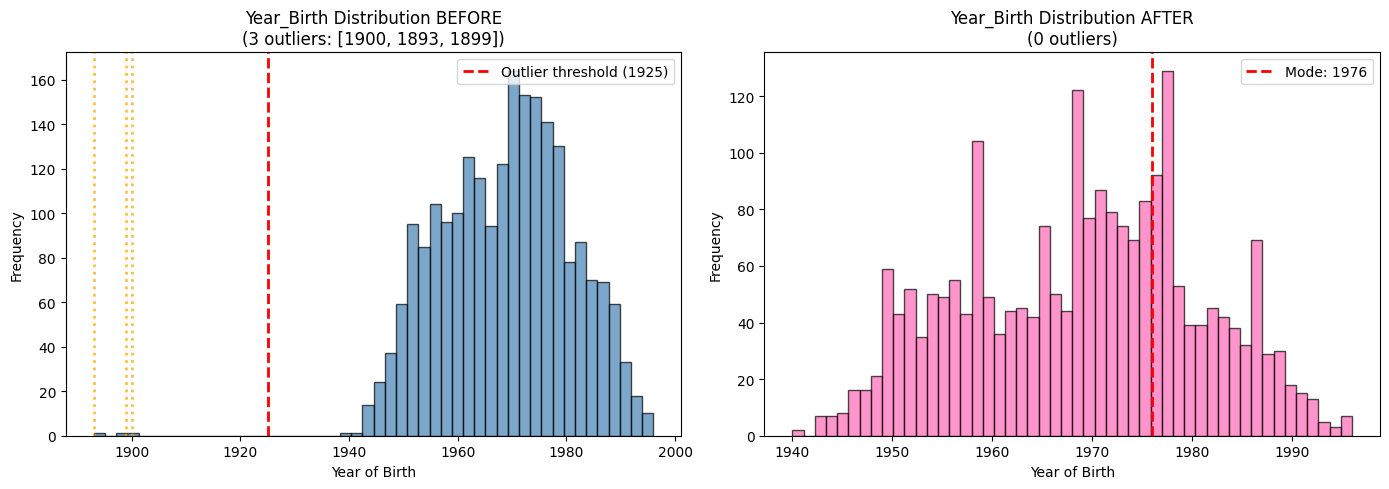


Age outlier handling for 'Year_Birth' attribute:
Outliers before: 3 (Year_Birth < 1925)
Outliers after:  0
Replacement method: Mode (1976)


In [47]:

# Reload original data to capture BEFORE state (in case cell is re-run)
ifood_df_original = pd.read_csv(os.path.join(marketing_data_path, "ml_project1_data.csv"))

#identify and visualize Age outliers
# Outliers from ORIGINAL data (birth year before 1925)
outlier_mask_original = ifood_df_original['Year_Birth'] < 1925
outliers_before = ifood_df_original[outlier_mask_original]['Year_Birth']
outlier_count_before = len(outliers_before)

plt.figure(figsize=(14, 5))

# Left plot: Year_Birth distribution BEFORE handling outliers (from original data)
plt.subplot(1, 2, 1)
plt.hist(ifood_df_original['Year_Birth'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(1925, color='red', linestyle='--', linewidth=2, label='Outlier threshold (1925)')
if outlier_count_before > 0:
    for year in outliers_before.unique():
        plt.axvline(year, color='orange', linestyle=':', linewidth=2, alpha=0.7)
plt.title(f'Year_Birth Distribution BEFORE\n({outlier_count_before} outliers: {[int(x) for x in outliers_before.unique()]})', fontsize=12)
plt.xlabel('Year of Birth')
plt.ylabel('Frequency')
plt.legend()

# Calculate mode for replacement (from non-outlier values in original data)
year_birth_mode = ifood_df_original[~outlier_mask_original]['Year_Birth'].mode()[0]
print(f"Year_Birth outliers found: {[int(x) for x in outliers_before.values]}")
print(f"Mode Year_Birth (for replacement): {int(year_birth_mode)}")

# Replace outliers with mode in working dataframe
outlier_mask = ifood_df['Year_Birth'] < 1925
ifood_df.loc[outlier_mask, 'Year_Birth'] = year_birth_mode

# Right plot: Year_Birth distribution AFTER handling outliers
outliers_after = ifood_df[ifood_df['Year_Birth'] < 1925]['Year_Birth']
outlier_count_after = len(outliers_after)

# Right plot: Year_Birth distribution AFTER handling outliers
plt.subplot(1, 2, 2)
plt.hist(ifood_df['Year_Birth'], bins=50, color='hotpink', edgecolor='black', alpha=0.7)
plt.axvline(year_birth_mode, color='red', linestyle='--', linewidth=2, label=f'Mode: {int(year_birth_mode)}')
plt.title(f'Year_Birth Distribution AFTER\n({outlier_count_after} outliers)', fontsize=12)
plt.xlabel('Year of Birth')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nAge outlier handling for 'Year_Birth' attribute:")
print(f"Outliers before: {outlier_count_before} (Year_Birth < 1925)")
print(f"Outliers after:  {outlier_count_after}")
print(f"Replacement method: Mode ({int(year_birth_mode)})")

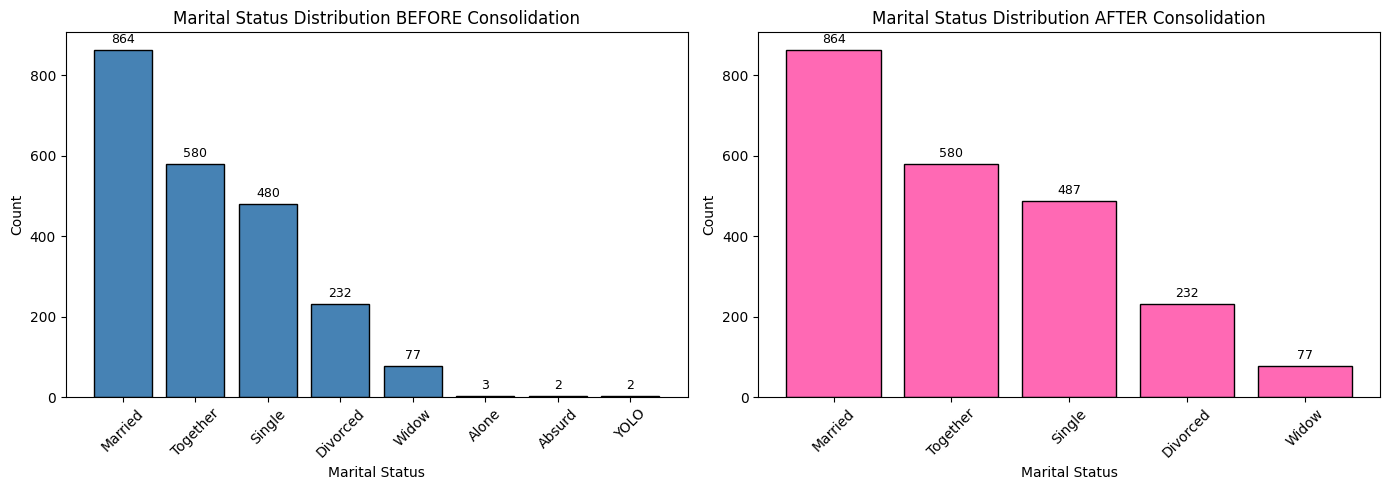

Single count BEFORE consolidation: 480
Single count AFTER consolidation: 487
Records consolidated (YOLO, Alone, Absurd -> Single): 7


In [48]:

# Reload original data to capture BEFORE state (in case cell is re-run)
ifood_df_original = pd.read_csv(os.path.join(marketing_data_path, "ml_project1_data.csv"))

# visualize Marital Status distribution
# Categories to consolidate
rare_categories = ['YOLO', 'Alone', 'Absurd']

# Marital Status BEFORE consolidation (from original data)
marital_before = ifood_df_original['Marital_Status'].value_counts()
records_to_consolidate = ifood_df_original['Marital_Status'].isin(rare_categories).sum()
colors_before = ['steelblue' if cat not in rare_categories else 'orange' 
                 for cat in marital_before.index]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
bars1 = plt.bar(marital_before.index, marital_before.values, color=colors_before, edgecolor='black')
plt.title('Marital Status Distribution BEFORE Consolidation', fontsize=12)
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
# Add count labels on bars
for bar, count in zip(bars1, marital_before.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, str(count), 
            ha='center', va='bottom', fontsize=9)

# Get Single count before consolidation
singles_before = marital_before.get('Single', 0)

# Consolidate rare categories to 'Single' in working dataframe
ifood_df['Marital_Status'] = ifood_df['Marital_Status'].replace(rare_categories, 'Single')

#Marital Status after consolidation
marital_after = ifood_df['Marital_Status'].value_counts()

plt.subplot(1, 2, 2)
bars2 = plt.bar(marital_after.index, marital_after.values, color='hotpink', edgecolor='black')
plt.title('Marital Status Distribution AFTER Consolidation', fontsize=12)
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
# Add count labels on bars
for bar, count in zip(bars2, marital_after.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, str(count), 
            ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

singles_after = marital_after.get('Single', 0)
print(f"Single count BEFORE consolidation: {singles_before}")
print(f"Single count AFTER consolidation: {singles_after}")
print(f"Records consolidated (YOLO, Alone, Absurd -> Single): {records_to_consolidate}")

Reference date (latest enrollment): 2014-06-29
Reference year for Age calculation: 2014


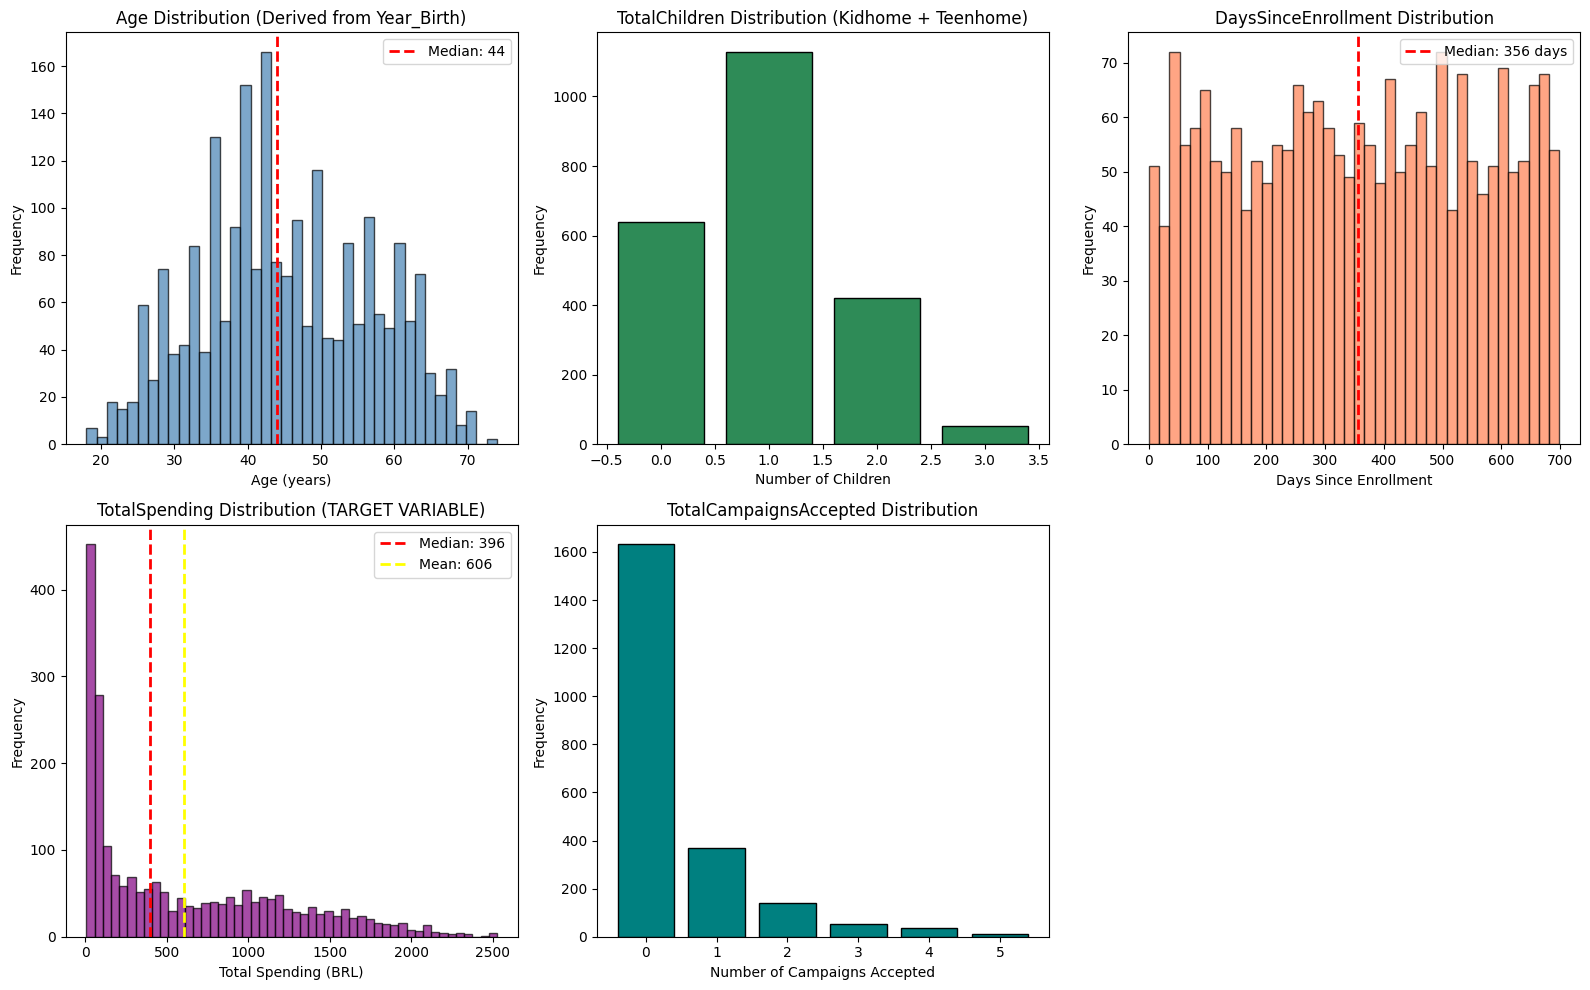

 DERIVED FEATURES SUMMARY 

           Age  TotalChildren  DaysSinceEnrollment  TotalCampaignsAccepted  \
count  2240.00        2240.00              2240.00                 2240.00   
mean     45.09           0.95               353.58                    0.45   
std      11.70           0.75               202.12                    0.89   
min      18.00           0.00                 0.00                    0.00   
25%      37.00           0.00               180.75                    0.00   
50%      44.00           1.00               355.50                    0.00   
75%      55.00           1.00               529.00                    1.00   
max      74.00           3.00               699.00                    5.00   

       TotalSpending  
count        2240.00  
mean          605.80  
std           602.25  
min             5.00  
25%            68.75  
50%           396.00  
75%          1045.50  
max          2525.00  
Dropped columns: ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp

In [49]:

# Convert Dt_Customer to datetime first to find the reference date
ifood_df['Dt_Customer'] = pd.to_datetime(ifood_df['Dt_Customer'])

# Use the latest enrollment date in the dataset as reference (data collection date)
reference_date = ifood_df['Dt_Customer'].max()
current_year = reference_date.year
print(f"Reference date (latest enrollment): {reference_date.date()}")
print(f"Reference year for Age calculation: {current_year}")

#  1. Create Age from Year_Birth 
ifood_df['Age'] = current_year - ifood_df['Year_Birth']

#  2. Create TotalChildren from Kidhome + Teenhome 
ifood_df['TotalChildren'] = ifood_df['Kidhome'] + ifood_df['Teenhome']

#  3. Create DaysSinceEnrollment from Dt_Customer 
ifood_df['DaysSinceEnrollment'] = (reference_date - ifood_df['Dt_Customer']).dt.days

#  4. Create TotalSpending (target variable) 
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 
                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
ifood_df['TotalSpending'] = ifood_df[spending_columns].sum(axis=1)

#  5. Create TotalCampaignsAccepted (combined campaign responsiveness) 
campaign_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 
                   'AcceptedCmp4', 'AcceptedCmp5', 'Response']
ifood_df['TotalCampaignsAccepted'] = ifood_df[campaign_columns].sum(axis=1)

#  Visualize the derived features
plt.figure(figsize=(16, 10))


# Age distribution
plt.subplot(2, 3, 1)
plt.hist(ifood_df['Age'], bins=40, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(ifood_df['Age'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {ifood_df['Age'].median():.0f}")
plt.title('Age Distribution (Derived from Year_Birth)', fontsize=12)
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.legend()

# TotalChildren distribution
children_counts = ifood_df['TotalChildren'].value_counts().sort_index()
plt.subplot(2, 3, 2)
plt.bar(children_counts.index, children_counts.values, color='seagreen', edgecolor='black')
plt.title('TotalChildren Distribution (Kidhome + Teenhome)', fontsize=12)
plt.xlabel('Number of Children')
plt.ylabel('Frequency')

# DaysSinceEnrollment distribution
plt.subplot(2, 3, 3)
plt.hist(ifood_df['DaysSinceEnrollment'], bins=40, color='coral', edgecolor='black', alpha=0.7)
plt.axvline(ifood_df['DaysSinceEnrollment'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {ifood_df['DaysSinceEnrollment'].median():.0f} days")
plt.title('DaysSinceEnrollment Distribution', fontsize=12)
plt.xlabel('Days Since Enrollment')
plt.ylabel('Frequency')
plt.legend()

# TotalSpending distribution
plt.subplot(2, 3, 4)
plt.hist(ifood_df['TotalSpending'], bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(ifood_df['TotalSpending'].median(), color='red', linestyle='--', linewidth=2, label=f"Median: {ifood_df['TotalSpending'].median():.0f}")
plt.axvline(ifood_df['TotalSpending'].mean(), color='yellow', linestyle='--', linewidth=2, label=f"Mean: {ifood_df['TotalSpending'].mean():.0f}")
plt.title('TotalSpending Distribution (TARGET VARIABLE)', fontsize=12)
plt.xlabel('Total Spending (BRL)')
plt.ylabel('Frequency')
plt.legend()

# TotalCampaignsAccepted distribution
campaign_counts = ifood_df['TotalCampaignsAccepted'].value_counts().sort_index()
plt.subplot(2, 3, 5)
plt.bar(campaign_counts.index, campaign_counts.values, color='teal', edgecolor='black')
plt.title('TotalCampaignsAccepted Distribution', fontsize=12)
plt.xlabel('Number of Campaigns Accepted')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Summary statistics for derived features
print(" DERIVED FEATURES SUMMARY \n")
derived_cols = ['Age', 'TotalChildren', 'DaysSinceEnrollment', 'TotalCampaignsAccepted', 'TotalSpending']
print(ifood_df[derived_cols].describe().round(2))



# Drop original columns that have been transformed into derived features
columns_to_drop = campaign_columns + spending_columns + ['Year_Birth', 'Kidhome', 'Teenhome', 'Dt_Customer']
ifood_df = ifood_df.drop(columns=columns_to_drop)
print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {list(ifood_df.columns)}")

 FEATURE STATISTICS AFTER SCALING 
        Income      Age  Recency  DaysSinceEnrollment  NumDealsPurchases  \
count  2240.00  2240.00  2240.00              2240.00            2240.00   
mean     -0.00    -0.00    -0.00                 0.00              -0.00   
std       1.00     1.00     1.00                 1.00               1.00   
min      -2.02    -2.32    -1.70                -1.75              -1.20   
25%      -0.67    -0.69    -0.87                -0.86              -0.69   
50%      -0.03    -0.09    -0.00                 0.01              -0.17   
75%       0.64     0.85     0.86                 0.87               0.35   
max      24.55     2.47     1.72                 1.71               6.56   

       NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
count          2240.00              2240.00            2240.00   
mean             -0.00                 0.00               0.00   
std               1.00                 1.00               1.00   
min             

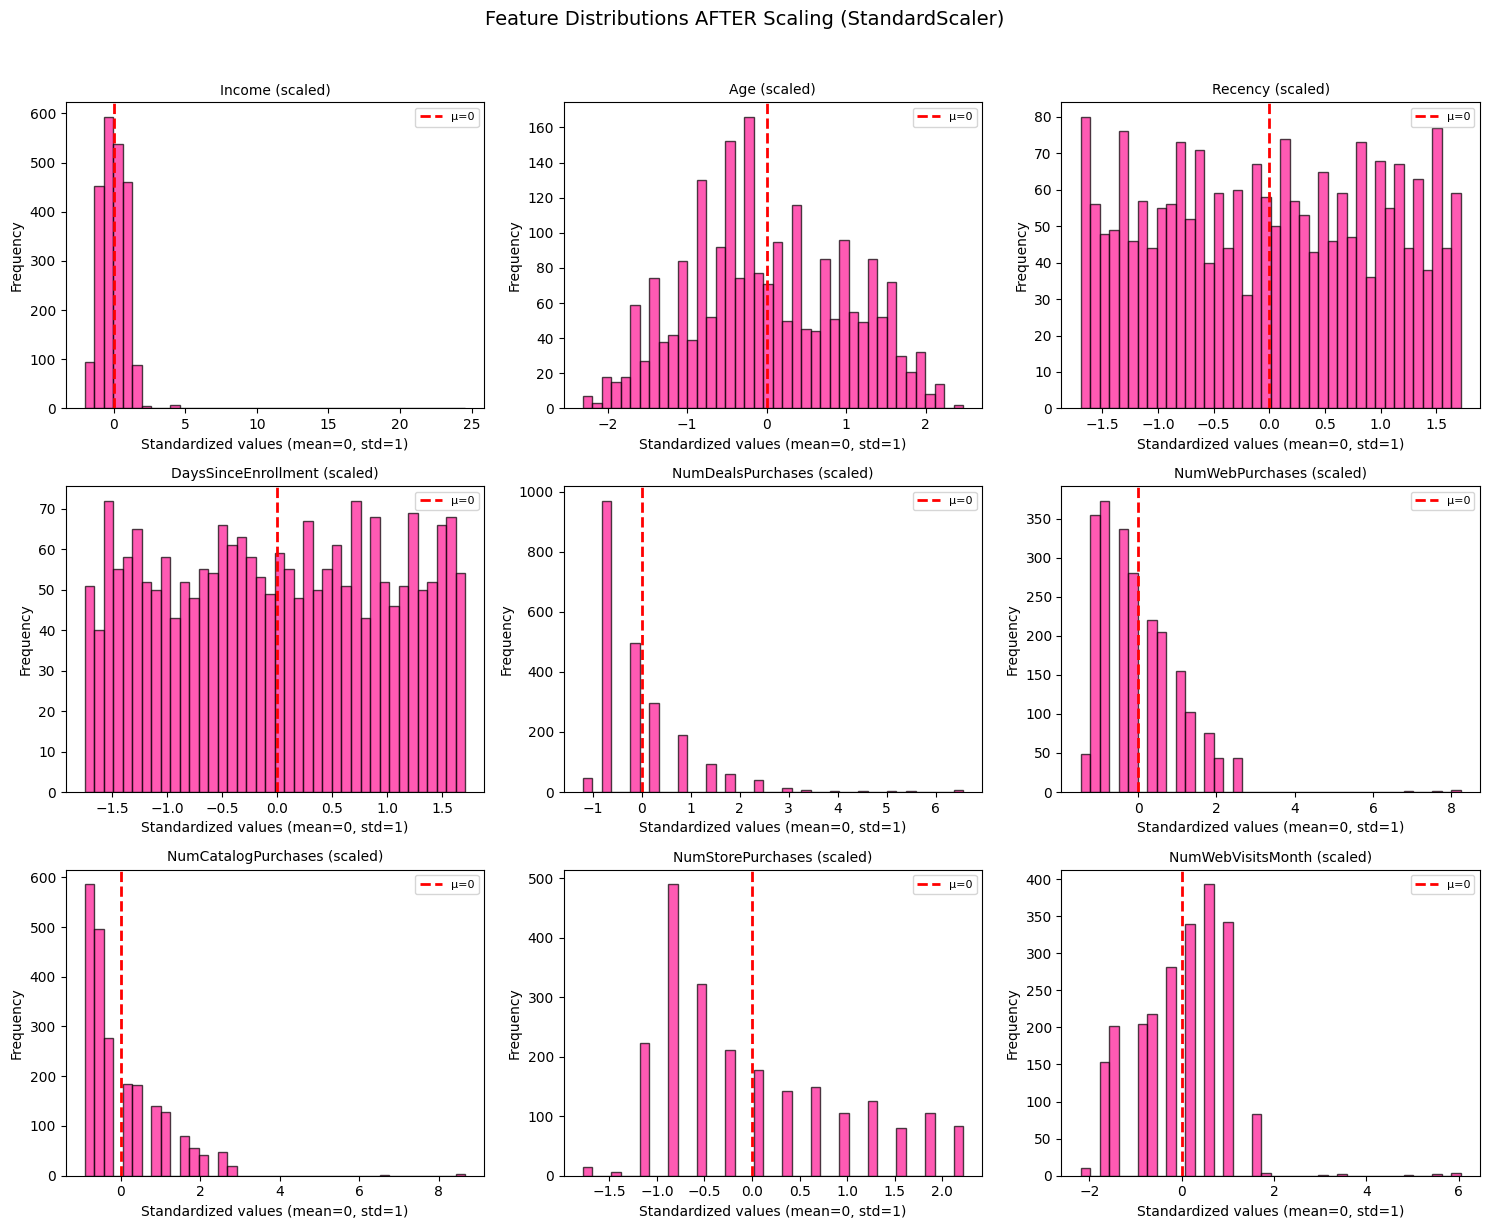


Scaled features: Income, Age, Recency, DaysSinceEnrollment, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Define features for different scaling methods
features_standard_scale = ['Income', 'Age', 'NumDealsPurchases', 'NumWebPurchases', 
                           'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']
features_minmax_scale = ['DaysSinceEnrollment', 'Recency']

# Apply StandardScaler to selected features
scaler_standard = StandardScaler()
ifood_df[features_standard_scale] = scaler_standard.fit_transform(ifood_df[features_standard_scale])

# Apply MinMaxScaler (0-1) to DaysSinceEnrollment and Recency
scaler_minmax = MinMaxScaler()
ifood_df[features_minmax_scale] = scaler_minmax.fit_transform(ifood_df[features_minmax_scale])

# Show scaled feature statistics
print("FEATURE STATISTICS AFTER SCALING\n")
print("StandardScaler features (mean=0, std=1):")
print(ifood_df[features_standard_scale].describe().round(2))
print("\nMinMaxScaler features (range 0-1):")
print(ifood_df[features_minmax_scale].describe().round(2))

# Visualize features AFTER scaling
all_scaled_features = features_standard_scale + features_minmax_scale
plt.figure(figsize=(15, 12))

for idx, feature in enumerate(all_scaled_features):
    plt.subplot(3, 3, idx + 1)
    color = 'deeppink' if feature in features_standard_scale else 'teal'
    plt.hist(ifood_df[feature], bins=40, color=color, edgecolor='black', alpha=0.7)
    
    if feature in features_standard_scale:
        plt.title(f'{feature} (StandardScaler)', fontsize=10)
        plt.xlabel('Standardized values (mean=0, std=1)')
        plt.axvline(0, color='red', linestyle='--', linewidth=2, label='μ=0')
    else:
        plt.title(f'{feature} (MinMaxScaler)', fontsize=10)
        plt.xlabel('Normalized values (0-1)')
        plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='midpoint=0.5')
    
    plt.ylabel('Frequency')
    plt.legend(fontsize=8)

plt.suptitle('Feature Distributions AFTER Scaling', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nStandardScaler applied to: {', '.join(features_standard_scale)}")
print(f"MinMaxScaler (0-1) applied to: {', '.join(features_minmax_scale)}")

In [ ]:

# Categorical columns to encode
categorical_cols = ['Education', 'Marital_Status']

# Check if encoding already applied (for re-run capability)
already_encoded = not all(col in ifood_df.columns for col in categorical_cols)

if already_encoded:
    # Reload original data and re-apply all transformations
    ifood_df_temp = pd.read_csv(os.path.join(marketing_data_path, "ml_project1_data.csv"))
    # Store original categorical values for BEFORE visualization
    original_cats = {col: ifood_df_temp[col].copy() for col in categorical_cols}
else:
    original_cats = {col: ifood_df[col].copy() for col in categorical_cols}

#  BEFORE: Show categorical distributions 
print("\nCategorical variables before one-hot encoding\n")
plt.figure(figsize=(14, 5))

for idx, col in enumerate(categorical_cols):
    plt.subplot(1, 2, idx + 1)
    value_counts = original_cats[col].value_counts()
    bars = plt.bar(value_counts.index, value_counts.values, color='steelblue', edgecolor='black')
    plt.title(f'{col} Distribution', fontsize=12)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    # Add count labels
    for bar, count in zip(bars, value_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, str(int(count)), 
                ha='center', va='bottom', fontsize=9)
    print(f"{col}:\n{value_counts}\n")

plt.tight_layout()
plt.show()

# Store original column counts
cols_before = len(ifood_df.columns)

# Apply one-hot encoding only if not already done
if not already_encoded:
    ifood_df = pd.get_dummies(ifood_df, columns=categorical_cols, drop_first=True)
else:
    print("(One-hot encoding already applied - showing existing encoded columns)")

# Get new column counts
cols_after = len(ifood_df.columns)
new_cols = cols_after - cols_before + len(categorical_cols)  # Account for dropped original cols

#  AFTER: Show encoded features 
print("\nCategorical variables after one-hot encoding")
print(f"\nColumns BEFORE encoding: {cols_before}")
print(f"Columns AFTER encoding:  {cols_after}")
print(f"New binary features created: {new_cols}")

# Display new encoded columns
encoded_cols = [col for col in ifood_df.columns if any(cat in col for cat in categorical_cols)]
print(f"\nNew encoded columns:")
for col in encoded_cols:
    print(f"  - {col}: {int(ifood_df[col].sum())} instances (value=1)")

# Visualize encoded features
plt.figure(figsize=(15, 8))

for idx, col in enumerate(encoded_cols[:6]):  # Show first 6 encoded columns
    plt.subplot(2, 3, idx + 1)
    counts = ifood_df[col].value_counts().sort_index()
    colors = ['lightgray', 'seagreen']
    plt.bar(counts.index.astype(str), counts.values, color=[colors[i] for i in counts.index], edgecolor='black')
    plt.title(f'{col}', fontsize=10)
    plt.xlabel('Value')
    plt.ylabel('Count')
    for i, (val, count) in enumerate(zip(counts.index, counts.values)):
        plt.text(i, count + 10, str(int(count)), ha='center', fontsize=9)

plt.suptitle('One-Hot Encoded Features', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:

# Columns excluded from analysis (as defined in Task 3.1 - Select Data)
excluded_from_analysis = ['ID', 'Z_CostContact', 'Z_Revenue', 'Complain']

# Get all numeric columns from transformed dataset, excluding non-predictive columns
numeric_features = [col for col in ifood_df.select_dtypes(include=[np.number]).columns.tolist()
                   if col not in excluded_from_analysis]

print(f"Excluded columns (no predictive value): {excluded_from_analysis}")
print(f"Analyzing {len(numeric_features)} numeric features\n")

# Calculate correlation matrix on transformed data
post_corr_matrix = ifood_df[numeric_features].corr()

# Create mask for upper triangle (to avoid redundancy)
mask = np.triu(np.ones_like(post_corr_matrix, dtype=bool))

# Plot correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(post_corr_matrix, mask=mask, cmap='coolwarm', center=0,
            annot=False, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation"})
plt.title('Post-Transformation Correlation Heatmap\n(After Data Preparation)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Identify highly correlated feature pairs (potential multicollinearity)
print("Multicolinearity check: Highly Correlated Feature Pairs")

# Unstack correlation matrix and filter
corr_unstacked = post_corr_matrix.where(mask == False).unstack().dropna()
high_corr_pairs = corr_unstacked[(abs(corr_unstacked) > 0.7) & (abs(corr_unstacked) < 1.0)].sort_values(ascending=False)

if len(high_corr_pairs) > 0:
    print(f"\nFeature pairs with |correlation| > 0.7:")
    print("-" * 50)
    seen_pairs = set()
    for (feat1, feat2), corr_val in high_corr_pairs.items():
        pair_key = tuple(sorted([feat1, feat2]))
        if pair_key not in seen_pairs:
            seen_pairs.add(pair_key)
            print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("\nNo highly correlated pairs found (|r| > 0.7)")

# Correlation with target variable (TotalSpending)
print("Correlation with Target (TotalSpending)")

if 'TotalSpending' in ifood_df.columns:
    target_corr = post_corr_matrix['TotalSpending'].drop('TotalSpending').sort_values(ascending=False)
    
    print("\nTop 10 positively correlated features:")
    for feat, corr_val in target_corr.head(10).items():
        print(f"  {feat}: {corr_val:.3f}")
    
    print("\nTop 5 negatively correlated features:")
    for feat, corr_val in target_corr.tail(5).items():
        print(f"  {feat}: {corr_val:.3f}")
else:
    print("\nTotalSpending not found in dataset - check derived features cell")

